In [1]:
import pandas as pd
import time
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
import pyarrow.parquet as pq

import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [5]:
# Загружаем файл с первым вариантом обработки данных, агрегация по mean.
file_path = 'data_mean_first_var.parquet'
table = pq.read_table(file_path)
df = table.to_pandas()
print(f"Обработка файла завершена.")

Обработка файла завершена.


In [8]:
df.total_delinquencies

0          4.900000
1          4.071429
2          4.000000
3          5.000000
4          5.000000
             ...   
2999995    4.272727
2999996    4.846154
2999997    4.600000
2999998    4.400000
2999999    4.500000
Name: total_delinquencies, Length: 3000000, dtype: float64

In [4]:
# Проверяем датафрейм
df.head(20)

,rn,pre_pterm,pre_fterm,pre_till_pclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,pre_loans_max_overdue_sum,pre_loans_credit_cost_rate,...,enc_paym_3,enc_paym_12,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
0,5.5,7.100000,7.500000,11.400000,9.600000,3.100000,2.900000,0.0,2.000000,8.000000,...,0.600000,1.800000,4.000000,1.000000,2.600000,3.500000,1.0,0.100000,0.200000,0
1,7.5,6.642857,7.928571,10.071429,8.142857,2.142857,2.928571,0.0,1.928571,3.714286,...,0.642857,1.714286,3.357143,1.000000,2.714286,3.142857,1.0,0.071429,0.142857,0
2,2.0,7.000000,6.000000,5.000000,1.666667,1.333333,3.000000,0.0,1.666667,4.000000,...,1.000000,2.333333,4.000000,1.000000,2.333333,3.333333,1.0,0.666667,0.666667,0
3,8.0,7.600000,7.800000,5.200000,9.866667,2.600000,3.266667,0.0,2.000000,4.466667,...,0.200000,1.200000,3.000000,1.000000,2.533333,3.600000,1.0,0.333333,0.400000,0
4,1.0,4.000000,8.000000,1.000000,12.000000,1.000000,3.000000,0.0,2.000000,0.000000,...,3.000000,3.000000,4.000000,1.000000,2.000000,3.000000,1.0,1.000000,1.000000,0
5,2.5,7.000000,7.500000,7.750000,11.750000,2.500000,2.750000,0.0,1.250000,6.000000,...,0.250000,2.500000,4.000000,1.000000,3.250000,3.250000,1.0,0.000000,0.250000,0
6,9.5,10.055556,9.055556,6.555556,11.055556,2.166667,3.055556,0.0,2.000000,4.000000,...,0.333333,1.500000,3.000000,1.000000,2.888889,3.555556,1.0,0.000000,0.055556,0
7,1.5,4.000000,8.000000,1.000000,3.500000,4.000000,3.500000,0.0,2.000000,2.000000,...,3.000000,3.000000,4.000000,1.000000,2.500000,3.000000,1.0,1.000000,1.000000,0
8,2.0,8.666667,12.000000,10.666667,14.000000,4.666667,3.666667,0.0,2.000000,2.666667,...,1.000000,2.000000,4.000000,1.000000,2.000000,3.666667,1.0,0.000000,0.333333,0
9,1.0,2.000000,10.000000,5.000000,12.000000,2.000000,3.000000,0.0,2.000000,4.000000,...,2.000000,1.000000,4.000000,1.000000,3.000000,4.000000,1.0,0.000000,0.000000,0


In [3]:
# Разделяем выборку
X = df.drop('flag', axis=1)
y = df['flag']

# Разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Применение ADASYN для балансировки тренировочных данных
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Создание и обучение модели случайного леса
start_time = time.time()

rf_model = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, class_weight='balanced', n_estimators=180, max_depth=30)
rf_model.fit(X_train_resampled, y_train_resampled)

elapsed_time_rf_adasyn = time.time() - start_time

# Прогнозирование на тестовом наборе
y_pred_rf = rf_model.predict(X_test)

# Рассчитываем ROC AUC
roc_auc_rf_adasyn = roc_auc_score(y_test, y_pred_rf)

# Вывод результатов
print(f'Метрика для случайного леса с использованием ADASYN: ROC AUC = {roc_auc_rf_adasyn}, Время на постройку: {elapsed_time_rf_adasyn}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  8.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.2s


Метрика для случайного леса с использованием ADASYN: ROC AUC = 0.5127227720002143, Время на постройку: 505.72089195251465


[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:   10.0s finished


In [7]:
ros = RandomOverSampler(sampling_strategy="not majority")
X_ros, y_ros = ros.fit_resample(X_train, y_train)

print(X_ros.shape)
print('________________________________')

print(y_ros.shape)
print('________________________________')

print(y_ros.value_counts())
print('________________________________')

(4629750, 35)
________________________________
(4629750,)
________________________________
flag
0    2314875
1    2314875
Name: count, dtype: int64
________________________________


In [8]:
# Создание и обучение модели случайного леса для oversampling
start_time = time.time()

rf_model_ros = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, class_weight='balanced', n_estimators=180, max_depth=30)
rf_model_ros.fit(X_ros, y_ros)

elapsed_time_rf_ros = time.time() - start_time

# Прогнозирование на тестовом наборе
y_pred_rf_ros = rf_model_ros.predict(X_test)

# Рассчитываем ROC AUC
roc_auc_rf_ros = roc_auc_score(y_test, y_pred_rf_ros)

# Вывод результатов
print(f'Метрика для случайного леса с использованием RandomOverSampling: ROC AUC = {roc_auc_rf_ros}, Время на постройку: {elapsed_time_rf_ros}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.1min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s


Метрика для случайного леса с использованием RandomOverSampling: ROC AUC = 0.5174147348223944, Время на постройку: 307.57297587394714


[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    5.9s finished


Матрица ошибок для случайного леса с использованием RandomOverSampling:
[[569900   8783]
 [ 20251   1066]]
Метрика для случайного леса с использованием RandomOverSampling: ROC AUC = 0.5174147348223944, Время на постройку: 307.57297587394714


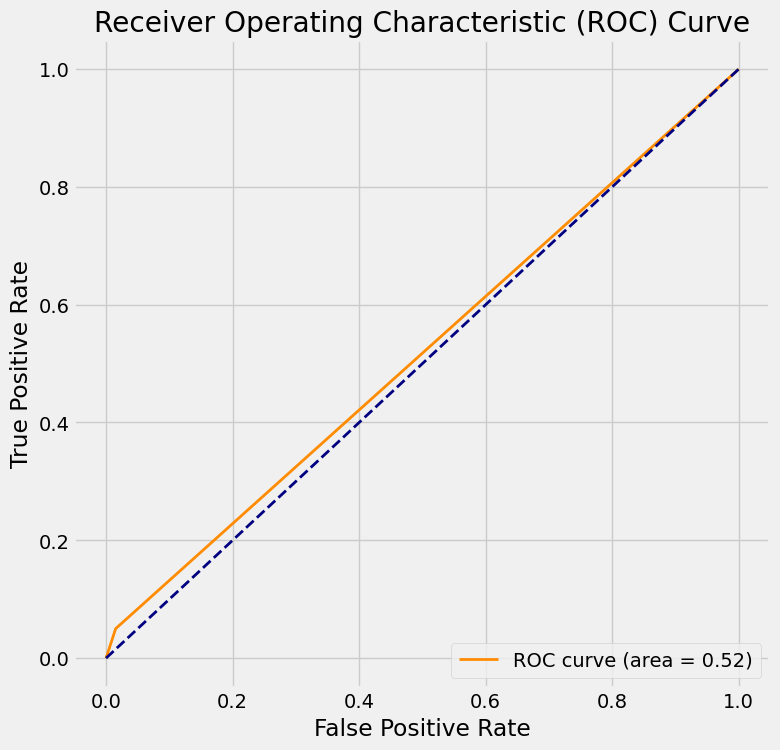

In [9]:
conf_matrix_rf_ros = confusion_matrix(y_test, y_pred_rf_ros)

# ROC-кривая
fpr_rf_ros, tpr_rf_ros, _ = roc_curve(y_test, y_pred_rf_ros)
roc_auc_rf_ros_curve = auc(fpr_rf_ros, tpr_rf_ros)

# Вывод результатов
print(f'Матрица ошибок для случайного леса с использованием RandomOverSampling:\n{conf_matrix_rf_ros}')
print(f'Метрика для случайного леса с использованием RandomOverSampling: ROC AUC = {roc_auc_rf_ros}, Время на постройку: {elapsed_time_rf_ros}')

# Визуализация ROC-кривой
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf_ros, tpr_rf_ros, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf_ros_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Как мы видим, добавление данных через RandomOverSampling или ADASYN не дает никаких положительных эффектов, однако undersampling показывает рост метрики, в том числе учитывая то, что в RUS мы передаем тренировочные данные, а тестовые данные остаются исходными. То есть модель способна адаптироваться на новых данных. 

In [4]:
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(X_rus.shape)
print('________________________________')

print(y_rus.shape)
print('________________________________')

print(y_rus.value_counts())
print('________________________________')

(170250, 37)
________________________________
(170250,)
________________________________
flag
0    85125
1    85125
Name: count, dtype: int64
________________________________


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed:    3.7s finished


Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = 0.6539609730005785, Время на постройку: 8.793081045150757
Матрица ошибок для случайного леса с использованием RandomUnderSampling:
[[372097 206586]
 [  7143  14174]]
Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = 0.6539609730005785, Время на постройку: 8.793081045150757


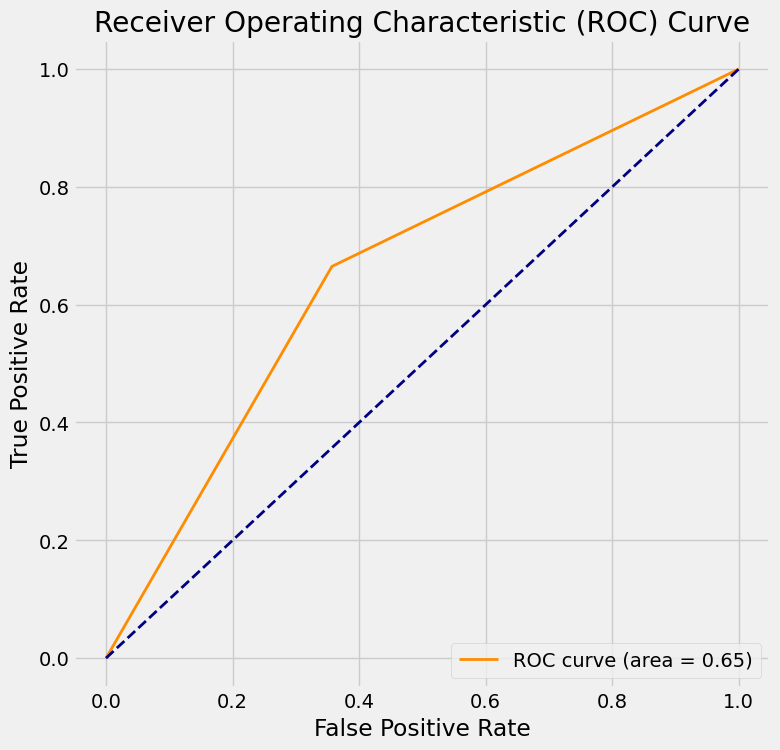

In [11]:
# Создание и обучение модели случайного леса
start_time = time.time()

rf_model_rus = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1, n_estimators=180, max_depth=30)
rf_model_rus.fit(X_rus, y_rus)

elapsed_time_rf_rus = time.time() - start_time

# Прогнозирование на тестовом наборе
y_pred_rf = rf_model_rus.predict(X_test)

# Рассчитываем ROC AUC
roc_auc_rf_rus = roc_auc_score(y_test, y_pred_rf)

# Вывод результатов
print(f'Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = {roc_auc_rf_rus}, Время на постройку: {elapsed_time_rf_rus}')

conf_matrix_rf_rus = confusion_matrix(y_test, y_pred_rf)

# ROC-кривая
fpr_rf_rus, tpr_rf_rus, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf_rus_curve = auc(fpr_rf_rus, tpr_rf_rus)

# Вывод результатов
print(f'Матрица ошибок для случайного леса с использованием RandomUnderSampling:\n{conf_matrix_rf_rus}')
print(f'Метрика для случайного леса с использованием RandomUnderSampling: ROC AUC = {roc_auc_rf_rus}, Время на постройку: {elapsed_time_rf_rus}')

# Визуализация ROC-кривой
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf_rus, tpr_rf_rus, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf_rus_curve))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Попробуем добавить разнообразие моделей.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_rus)
X_test_scaled = scaler.transform(X_test)

In [13]:
start_time = time.time()
# Модель ближайших соседей

knn_model_balanced = KNeighborsClassifier(n_neighbors=6, weights='distance', algorithm='auto') 
knn_model_balanced.fit(X_train_scaled, y_rus)

# Делаем предсказания на тестовом наборе данных
y_pred = knn_model_balanced.predict(X_test_scaled)

roc_auc_knn_balanced = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc_knn_balanced}')

# Строим матрицу ошибок
conf_matrix_knn_balanced = confusion_matrix(y_test, y_pred)
print('Матрица ошибок:')
print(conf_matrix_knn_balanced)

end_time = time.time()
elapsed_time_knn_balanced = end_time - start_time
print(f'Время на постройку модели: {elapsed_time_knn_balanced:.2f} секунд')

ROC AUC: 0.610223730891522
Матрица ошибок:
[[362414 216269]
 [  8651  12666]]
Время на постройку модели: 53.02 секунд


GradientBoostingClassifier:
Confusion Matrix:
[[375697 202986]
 [  7358  13959]]

ROC AUC: 0.7096846489989201


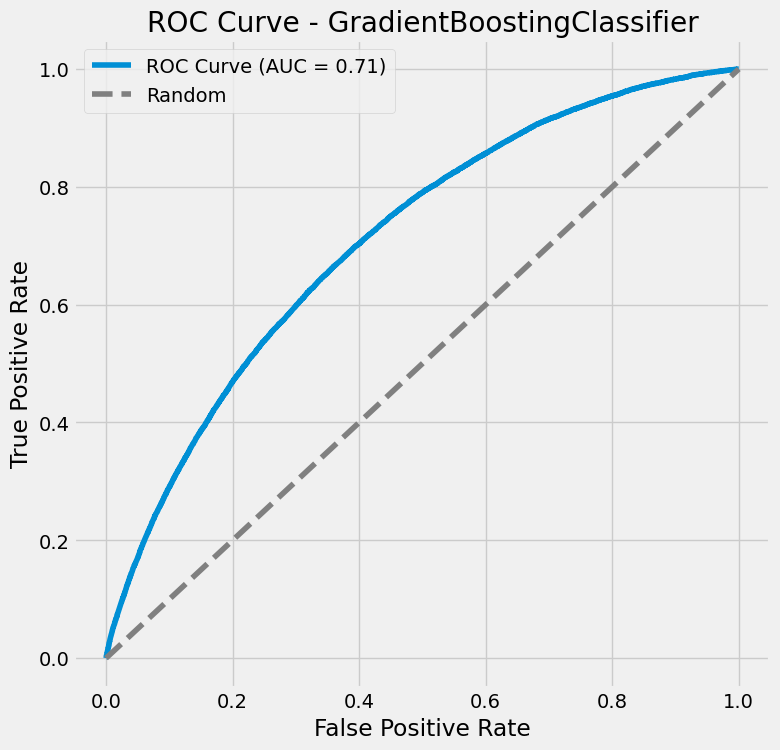

In [14]:
# GradientBoostingClassifier
gb_model = GradientBoostingClassifier()
gb_model.fit(X_rus, y_rus)

y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

roc_auc_gb = roc_auc_score(y_test, y_proba_gb)

# Выводим матрицу ошибок и другие метрики
print("GradientBoostingClassifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))
print("\nROC AUC:", roc_auc_gb)

# Рисуем ROC-кривую
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_proba_gb)
plt.figure(figsize=(8, 8))
plt.plot(fpr_gb, tpr_gb, label=f'ROC Curve (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - GradientBoostingClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.092386
0:	learn: 0.6848991	total: 80.8ms	remaining: 1m 20s
1:	learn: 0.6777567	total: 92.7ms	remaining: 46.3s
2:	learn: 0.6717367	total: 105ms	remaining: 34.9s
3:	learn: 0.6667920	total: 119ms	remaining: 29.6s
4:	learn: 0.6623121	total: 132ms	remaining: 26.4s
5:	learn: 0.6583380	total: 145ms	remaining: 24s
6:	learn: 0.6550544	total: 158ms	remaining: 22.4s
7:	learn: 0.6521984	total: 171ms	remaining: 21.2s
8:	learn: 0.6496049	total: 184ms	remaining: 20.2s
9:	learn: 0.6472307	total: 198ms	remaining: 19.6s
10:	learn: 0.6451495	total: 211ms	remaining: 19s
11:	learn: 0.6432841	total: 225ms	remaining: 18.5s
12:	learn: 0.6416455	total: 238ms	remaining: 18.1s
13:	learn: 0.6403415	total: 251ms	remaining: 17.7s
14:	learn: 0.6389964	total: 264ms	remaining: 17.3s
15:	learn: 0.6378567	total: 277ms	remaining: 17.1s
16:	learn: 0.6368403	total: 290ms	remaining: 16.8s
17:	learn: 0.6358069	total: 304ms	remaining: 16.6s
18:	learn: 0.6349143	total: 317ms	remaining: 16.4s
19:	learn: 0

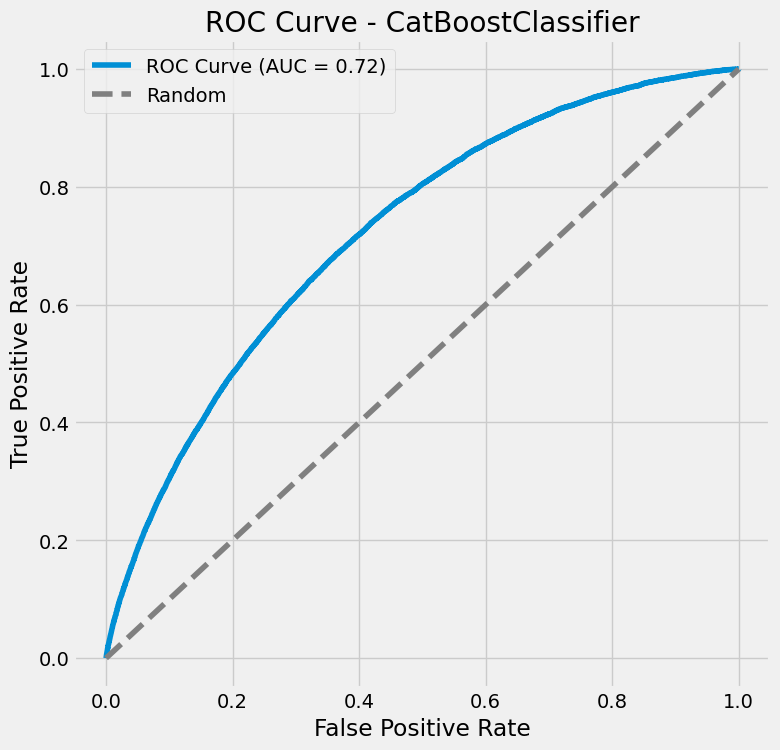

In [15]:
# CatBoostClassifier
cat_model = CatBoostClassifier()
cat_model.fit(X_train_scaled, y_rus, plot=True)
y_proba_cat = cat_model.predict_proba(X_test_scaled)[:, 1]
roc_auc_cat = roc_auc_score(y_test, y_proba_cat)
print("\nROC AUC:", roc_auc_cat)

# Рисуем ROC-кривую
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_proba_cat)
plt.figure(figsize=(8, 8))
plt.plot(fpr_cat, tpr_cat, label=f'ROC Curve (AUC = {roc_auc_cat:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - CatBoostClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

                          Feature  Importance
31          enc_loans_credit_type    7.564364
16               is_zero_loans530    7.368202
26                     enc_paym_3    7.047232
23                   is_zero_util    6.613021
27                    enc_paym_12    5.304114
20                       pre_util    4.780451
0                              rn    4.409053
15                 is_zero_loans5    3.869884
17              is_zero_loans3060    3.715532
6           pre_loans_outstanding    3.620446
30        enc_loans_credit_status    3.614722
1                       pre_pterm    3.447419
4          pre_loans_credit_limit    3.394626
3                 pre_till_pclose    3.354215
9      pre_loans_credit_cost_rate    3.210384
28                    enc_paym_24    3.094017
5         pre_loans_next_pay_summ    2.954658
2                       pre_fterm    2.639108
8       pre_loans_max_overdue_sum    2.401556
34                    fclose_flag    2.337989
21                 pre_over2limit 

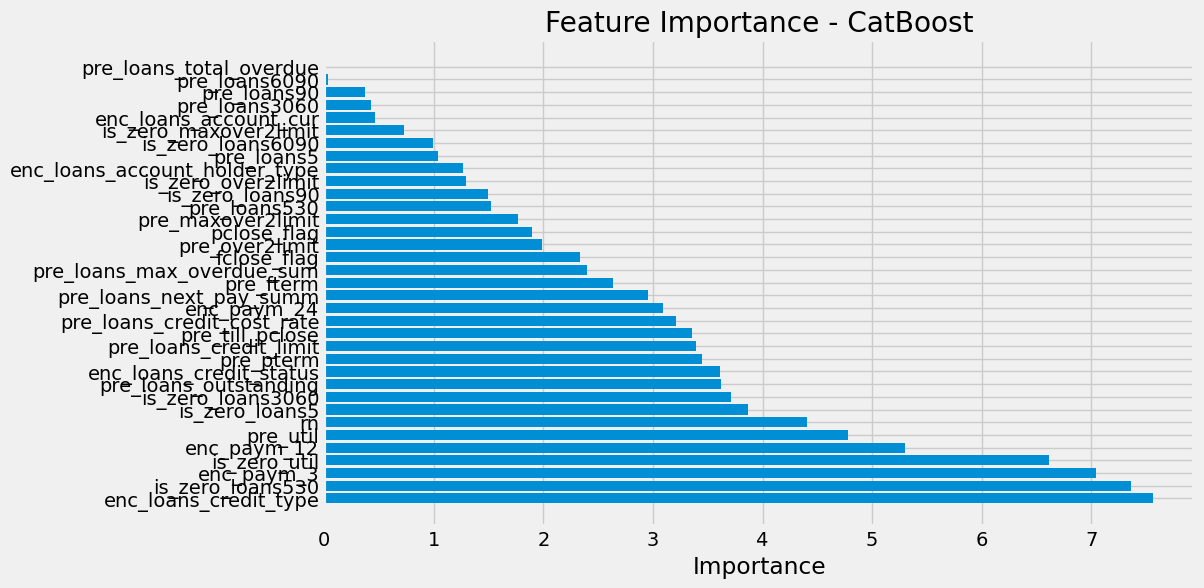

In [17]:
feature_importance = cat_model.feature_importances_
# Создаем DataFrame с именами признаков и их важностями, чтобы посмотреть на важность признаков в catboost, так как он выдает лучшую метрику
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Сортируем признаки по важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Выводим важности признаков
print(feature_importance_df)

# Рисуем график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - CatBoost')
plt.show()

Как мы видим модель использовала почти все признаки для обучения, поэтому имеет смысл вернуться к обработке данных и вернуть удаленные фичи. 

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 85125, number of negative: 85125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5673
[LightGBM] [Info] Number of data points in the train set: 170250, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

LGBMClassifier:
Confusion Matrix:
[[367

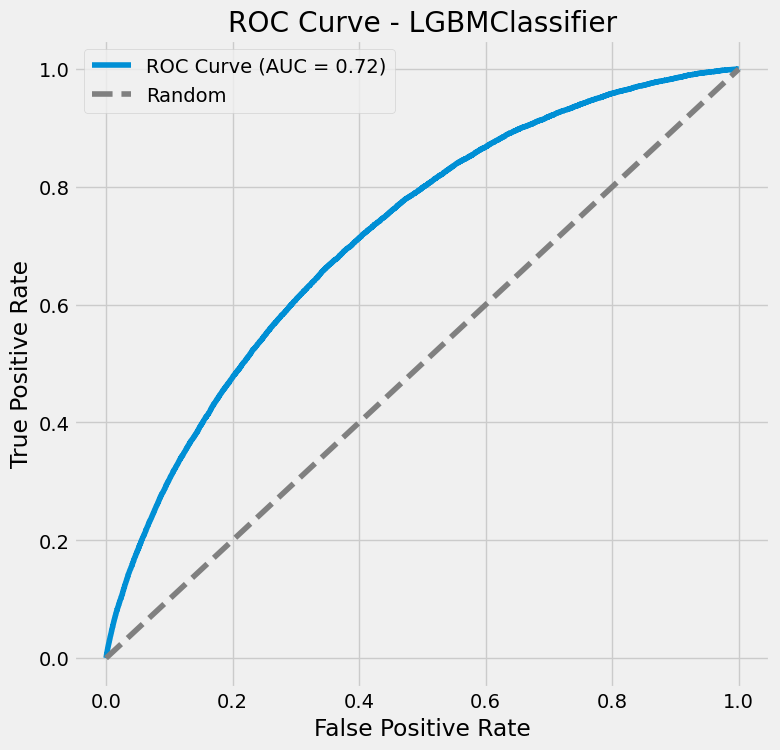

In [18]:
# LGBMClassifier
lgb_model = lgb.LGBMClassifier(max_depth=10)
lgb_model.fit(X_train_scaled, y_rus)

y_pred_lgb = lgb_model.predict(X_test_scaled)
y_proba_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

# Выводим матрицу ошибок и другие метрики
print("\nLGBMClassifier:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print("\nROC AUC:", roc_auc_lgb)

# Рисуем ROC-кривую
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_proba_lgb)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lgb, tpr_lgb, label=f'ROC Curve (AUC = {roc_auc_lgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.title('ROC Curve - LGBMClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [20]:
base_models = [
    ('gradient_boosting', GradientBoostingClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=1000)),
    ('catboost', CatBoostClassifier(random_state=42, eval_metric='AUC', boosting_type='Ordered', eta=0.02, depth=6, bootstrap_type='Bernoulli', iterations=1500, l2_leaf_reg=4)),
    ('lgbm', lgb.LGBMClassifier(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=1500))
]

# Метамодель 
meta_model = CatBoostClassifier()

# Создание модели стекинга
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Обучение модели стекинга
stacking_model.fit(X_train_scaled, y_rus)

# Получение предсказаний
y_proba_stacking = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Оценка производительности
auc_stacking = roc_auc_score(y_test, y_proba_stacking)
print("AUC with Stacking:", auc_stacking)

0:	total: 42.1ms	remaining: 1m 3s
1:	total: 84.7ms	remaining: 1m 3s
2:	total: 124ms	remaining: 1m 1s
3:	total: 168ms	remaining: 1m 2s
4:	total: 212ms	remaining: 1m 3s
5:	total: 256ms	remaining: 1m 3s
6:	total: 302ms	remaining: 1m 4s
7:	total: 350ms	remaining: 1m 5s
8:	total: 391ms	remaining: 1m 4s
9:	total: 435ms	remaining: 1m 4s
10:	total: 475ms	remaining: 1m 4s
11:	total: 533ms	remaining: 1m 6s
12:	total: 578ms	remaining: 1m 6s
13:	total: 626ms	remaining: 1m 6s
14:	total: 665ms	remaining: 1m 5s
15:	total: 706ms	remaining: 1m 5s
16:	total: 747ms	remaining: 1m 5s
17:	total: 807ms	remaining: 1m 6s
18:	total: 852ms	remaining: 1m 6s
19:	total: 892ms	remaining: 1m 5s
20:	total: 938ms	remaining: 1m 6s
21:	total: 982ms	remaining: 1m 5s
22:	total: 1.02s	remaining: 1m 5s
23:	total: 1.06s	remaining: 1m 5s
24:	total: 1.11s	remaining: 1m 5s
25:	total: 1.16s	remaining: 1m 5s
26:	total: 1.2s	remaining: 1m 5s
27:	total: 1.25s	remaining: 1m 5s
28:	total: 1.29s	remaining: 1m 5s
29:	total: 1.33s	remain

In [21]:
voting_classifier = VotingClassifier(
    estimators=[
        ('lgbm', lgb_model),
        ('catboost', cat_model),
        ('gradientboost', gb_model)
    ],
    voting='soft' 
)

voting_classifier.fit(X_train_scaled, y_rus)

predictions = voting_classifier.predict(X_test_scaled)


from sklearn.metrics import roc_auc_score

y_probs = voting_classifier.predict_proba(X_test_scaled)[:, 1] 

roc_auc = roc_auc_score(y_test, y_probs)

print(f'ROC AUC: {roc_auc}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 85125, number of negative: 85125
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5673
[LightGBM] [Info] Number of data points in the train set: 170250, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Learning rate set to 0.092386
0:	learn: 0.6848991	total: 15.4ms	remaining: 15.3s
1:	learn: 0.6777567	total: 30.7ms	remaining: 15.3s
2:	learn: 0.6717367	total: 43.8ms	remaining: 14.6s
3:	learn: 0.6667920	total: 58.5ms	remaining: 14.6s
4:

In [6]:
# Обучение SVM
svm_model = SVC(kernel='rbf', probability=True)

# Обучение k-NN
knn_model = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)

# Обучение CatBoost
catboost_model = CatBoostClassifier(random_state=42, eval_metric='AUC', boosting_type='Ordered', eta=0.02, depth=6, bootstrap_type='Bernoulli', iterations=1500, l2_leaf_reg=4)

# Голосование (voting)
voting_classifier = VotingClassifier(
    estimators=[('svm', svm_model), ('knn', knn_model), ('catboost', catboost_model)],
    voting='soft'
)

voting_classifier.fit(X_train_scaled, y_rus)
voting_preds = voting_classifier.predict_proba(X_test_scaled)[:, 1]

# Рассчитываем ROC AUC для голосования
voting_roc_auc = roc_auc_score(y_test, voting_preds)
print(f"Voting ROC AUC: {voting_roc_auc}")

0:	total: 123ms	remaining: 3m 3s
1:	total: 168ms	remaining: 2m 5s
2:	total: 208ms	remaining: 1m 43s
3:	total: 247ms	remaining: 1m 32s
4:	total: 286ms	remaining: 1m 25s
5:	total: 328ms	remaining: 1m 21s
6:	total: 367ms	remaining: 1m 18s
7:	total: 409ms	remaining: 1m 16s
8:	total: 453ms	remaining: 1m 15s
9:	total: 497ms	remaining: 1m 14s
10:	total: 538ms	remaining: 1m 12s
11:	total: 581ms	remaining: 1m 12s
12:	total: 639ms	remaining: 1m 13s
13:	total: 678ms	remaining: 1m 11s
14:	total: 716ms	remaining: 1m 10s
15:	total: 756ms	remaining: 1m 10s
16:	total: 796ms	remaining: 1m 9s
17:	total: 839ms	remaining: 1m 9s
18:	total: 884ms	remaining: 1m 8s
19:	total: 935ms	remaining: 1m 9s
20:	total: 975ms	remaining: 1m 8s
21:	total: 1.01s	remaining: 1m 8s
22:	total: 1.05s	remaining: 1m 7s
23:	total: 1.1s	remaining: 1m 7s
24:	total: 1.14s	remaining: 1m 7s
25:	total: 1.2s	remaining: 1m 7s
26:	total: 1.25s	remaining: 1m 8s
27:	total: 1.29s	remaining: 1m 7s
28:	total: 1.33s	remaining: 1m 7s
29:	total: 1

Как можно видеть, данные очень плохо реагируют на эксперименты. Лучшая модель получилась Catboost, варианты с использованием ансамблей, стекинга и голосования показывают худшую эффективность, чем использование самостоятельной модели. Также видим, что oversampling не дал никакого полезного эффекта, следует отметить, что и концепция создания новых данных путем размножения имеющихся довольно сомнительна. Попробуем изменить данные в Compile_dataset_ohe_part: нужно закодировать явные столбцы с пометкой "закодировано", которые выражены числами, но не имеют числового основания под собой, а следовательно их можно считать категориальными и продолжим эксперименты в Modelling_Under_sampling_part_ohe. Предварительно удалим самые непроизводительные варианты, это метод голосования, на который уходит больше всего времени. Все остальные посмотрим как ведут себя при измененных данных. Стекинг можно оставить, несмотря на то, что в нем участвует 3 похожих модели, он показал относительно неплохой результат.  